This is version 2 of the notebook using the dataset with actual response variables.

# TODO

- rerun manova and put it into function
- NEED MORE DATA POINTS
- dendrogram: which groups are closest
- ask Cory whether inverse PCA transformation can be used to get transformation for future data points to be comparable (the 'index' idea)

# NOTES
- my response really is 'Group', not 'NVC' (this is changes from version 0 and first drafts of version 2) - OR IS IT?

In [330]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from vacou import *
from plots import *
from sklearn.metrics.pairwise import pairwise_distances

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
sns.set(style="white")
#sns.set(font="monospace")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [331]:
data_fp = '/P/vacou/data/SS31_gait_data_for_PCA.tsv'
#d_orig = pd.read_csv(data_fp, sep='\t')
response_column = 'Group'

In [332]:
d, md, full_df = preprocess_vc(data_fp, version = 2, use_vars_fp='data/use_variables.csv')

In [333]:
print(d.shape, md.shape, full_df.shape)

(45, 112) (45, 2) (45, 192)


In [334]:
#d.to_csv('data/data_ss31.tsv', sep='\t')
#md.to_csv('data/md.tsv', sep='\t')
#full_df.to_csv('data/data_ss31_with_md.tsv', sep="\t")

In [335]:
d

Run_Average_Speed_(cm/s)_Mean  RF_StandIndex_Mean  \
Group              Animal                                                      
young ctrl         1.1                         15.368212           -3.920019   
                   1.2                         14.152257           -3.501794   
                   1.3                         20.820103           -3.884948   
                   1.4                         15.520898           -3.532775   
                   3.2                         14.823663           -3.563510   
                   3.3                         12.077534           -5.094304   
                   3.4                         14.543160           -3.388024   
                   4.1                         14.172776           -2.700256   
                   4.2                         15.478490           -3.666499   
                   4.3                         10.371507           -3.062101   
                   4.4                          9.636693           -2.745969   
                   5.1                         15.191048           -3.937201   
                   5.2                         10.165901           -3.764148   
                   5.3                          8.233310           -2.265671   
                   5.4                          9.916233           -3.302005   
Aged Ctrl          1.1                         15.748477           -3.062021   
                   1.2                         14.632895           -3.019088   
                   1.3                         13.795579           -2.845816   
                   1.4                         15.811258           -2.337280   
                   2.1                         18.508012           -3.378509   
                   2.2                         14.025465           -2.633040   
                   2.3                         16.656712           -2.936987   
                   2.4                         18.162304           -1.907316   
                   3.1                         12.439093           -2.522384   
                   3.2                         12.741593           -2.174717   
ss31 aged injected 1.1                         13.960325           -2.423437   
                   1.2                         15.582630           -2.294011   
                   1.3                         13.170207           -2.576122   
                   1.4                         17.251143           -2.593053   
                   2.1                         13.738379           -2.711121   
                   2.2                         21.285255           -2.500035   
                   2.3                         23.974459           -4.410566   
                   2.4                         36.367256           -5.539478   
                   3.1                         13.344877           -2.016830   
                   3.2                         16.743473           -3.471036   
                   3.3                         14.060619           -2.165753   
                   3.4                         14.134415           -1.927749   
                   4.1                         14.814096           -2.623676   
                   4.2                         13.856238           -2.695947   
                   4.3                         15.998482           -2.993544   
                   4.4                         14.133410           -2.831298   
                   5.1                         20.619633           -2.662863   
                   5.2                         17.705137           -2.923169   
                   5.3                         18.641600           -3.228503   
                   5.4                         14.787200           -2.328521   

                           RF_MaxContactAt_(%)_Mean  RF_Swing_(s)_Mean  \
Group              Animal                                                
young ctrl         1.1                    34.480518           0.176112   
                   1.2                    42

# Exploratory

In [336]:
full_df.columns.tolist()[:20]

['Group',
 'Animal',
 'Run_Duration_(s)_Mean',
 'Run_Average_Speed_(cm/s)_Mean',
 'Run_Maximum_Variation_(%)_Mean',
 'RF_Stand_(s)_Mean',
 'RF_StandIndex_Mean',
 'RF_MaxContactAt_(%)_Mean',
 'RF_MaxContactArea_(cm²)_Mean',
 'RF_MaxContactMaxIntensity_Mean',
 'RF_MaxContactMeanIntensity_Mean',
 'RF_PrintLength_(cm)_Mean',
 'RF_PrintWidth_(cm)_Mean',
 'RF_PrintArea_(cm²)_Mean',
 'RF_MaxIntensityAt_(%)_Mean',
 'RF_MaxIntensity_Mean',
 'RF_MinIntensity_Mean',
 'RF_MeanIntensity_Mean',
 'RF_MeanIntensityOfThe15MostIntensePixels_Mean',
 'RF_Swing_(s)_Mean']

In [337]:
d.describe()

,Run_Average_Speed_(cm/s)_Mean,RF_StandIndex_Mean,RF_MaxContactAt_(%)_Mean,RF_Swing_(s)_Mean,RF_SwingSpeed_(cm/s)_Mean,RF_StrideLength_(cm)_Mean,RF_StepCycle_(s)_Mean,RF_DutyCycle_(%)_Mean,RF_SingleStance_(s)_Mean,RF_InitialDualStance_(s)_Mean,...,LF_BodySpeedVariation_(%)_Mean,LH_Stand_(s)_Mean,LH_StandIndex_Mean,LH_MaxContactAt_(%)_Mean,LH_Swing_(s)_Mean,LH_SwingSpeed_(cm/s)_Mean,LH_StrideLength_(cm)_Mean,LH_StepCycle_(s)_Mean,LH_DutyCycle_(%)_Mean,LH_SingleStance_(s)_Mean
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,15.492489,-3.023624,39.615562,0.165033,44.014118,6.326141,0.392749,57.856142,0.153877,0.036273,...,29.695562,0.262652,-6.517368,34.350668,0.130120,49.725466,6.098902,0.387094,63.632345,0.125360
std,4.447181,0.774734,5.762326,0.026097,7.587482,0.845784,0.052821,2.534930,0.023804,0.011402,...,8.929126,0.049168,1.712988,6.160769,0.026428,8.824091,0.955912,0.053425,5.208430,0.027986
min,8.233310,-5.539478,25.672339,0.122154,32.192698,4.544817,0.293732,52.288255,0.096604,0.015602,...,16.166612,0.169034,-11.976545,22.506915,0.083153,30.267242,3.859356,0.280508,53.652073,0.084439
25%,13.795579,-3.471036,34.480518,0.145762,39.155787,5.713459,0.361386,56.109165,0.140178,0.029114,...,22.636445,0.225131,-7.490272,29.400657,0.117073,44.535744,5.485780,0.352589,59.581155,0.107855
50%,14.787200,-2.845816,40.175398,0.160970,42.595346,6.343130,0.394577,57.581419,0.152672,0.035215,...,28.995632,0.258668,-6.335093,34.587902,0.127147,50.124704,6.238482,0.388277,64.359498,0.117324
75%,16.656712,-2.522384,42.746750,0.188699,46.903520,6.857050,0.432204,59.103890,0.169052,0.043986,...,34.241979,0.303177,-5.357041,38.768692,0.137161,54.770870,6.873361,0.425085,68.063272,0.139033
max,36.367256,-1.907316,52.107865,0.216407,71.448406,8.215144,0.486805,63.626018,0.207266,0.063617,...,57.471771,0.354071,-3.522899,47.127878,0.221950,72.947443,8.112944,0.486316,73.572929,0.222574


In [338]:
md.head()

Group Animal
Group      Animal                   
young ctrl 1.1     young ctrl    1.1
           1.2     young ctrl    1.2
           1.3     young ctrl    1.3
           1.4     young ctrl    1.4
           3.2     young ctrl    3.2

In [339]:
pd.DataFrame(md.Group.value_counts())

,Group
ss31 aged injected,20
young ctrl,15
Aged Ctrl,10


# Top important features

### highest variance selection

In [215]:
selected_v, variances = sel_var(normalize_pd(d, 0), 0.001)

In [340]:
print("Features with highest variance")
pd.DataFrame(variances.sort_values(ascending=False)[:15], columns = ['variance (after normalisation)'])

Features with highest variance


,variance (after normalisation)
LH_InitialDualStance_(s)_Mean,0.003516
RH_TerminalDualStance_(s)_Mean,0.003433
RH_TerminalDualStance_(s)_Mean,0.003433
RH_InitialDualStance_(s)_Mean,0.003318
RH_InitialDualStance_(s)_Mean,0.003318
LF_InitialDualStance_(s)_Mean,0.003230
LF_InitialDualStance_(s)_Mean,0.003230
RF_TerminalDualStance_(s)_Mean,0.002905
RF_TerminalDualStance_(s)_Mean,0.002905
LH_TerminalDualStance_(s)_Mean,0.002823


### f classification selection (anova for all variables)

In [217]:
selected_a = sel_anova(normalize_pd(d, 0), md[response_column], k=15, mode = 'classif')

In [218]:
print("Features selected by f_regression")
pd.DataFrame(selected_a.columns)

Features selected by f_regression


,0
0,RF_StrideLength_(cm)_Mean
1,RH_StrideLength_(cm)_Mean
2,RH_SingleStance_(s)_Mean
3,LF_StrideLength_(cm)_Mean
4,LH_Swing_(s)_Mean
5,LH_StrideLength_(cm)_Mean
6,LH_SingleStance_(s)_Mean
7,FP_StrideLength_(cm)_Mean
8,RF_StrideLength_(cm)_Mean
9,RH_StrideLength_(cm)_Mean


### mutual information classification selection

In [219]:
selected_m = sel_mi(normalize_pd(d, 0), md[response_column], k=15)

In [220]:
print("Features selected by mutual_info_regression")
pd.DataFrame(selected_m.columns)

Features selected by mutual_info_regression


,0
0,RF_StrideLength_(cm)_Mean
1,RH_StrideLength_(cm)_Mean
2,LF_StrideLength_(cm)_Mean
3,LF_BodySpeed_(cm/s)_Mean
4,LH_StrideLength_(cm)_Mean
5,LH_SingleStance_(s)_Mean
6,LH_BodySpeed_(cm/s)_Mean
7,FP_StrideLength_(cm)_Mean
8,FP_BodySpeed_(cm/s)_Mean
9,RF_StrideLength_(cm)_Mean


### Comparison of feature reduction methods

In [224]:
print("Number of selected features that overlap between methods (out of 15):")
print(' - var-f_reg:', str(sum([i in selected_a.columns.tolist()
                              for i in variances.sort_values(ascending=False)[:15].index.tolist()])),
                             "features.")
print(' - var-mi_reg:', str(sum([i in selected_m.columns.tolist()
                              for i in variances.sort_values(ascending=False)[:15].index.tolist()])),
                             "features.")
print(' - f_reg-mi_reg:', str(sum([i in selected_a.columns.tolist()
                              for i in selected_m.columns.tolist()])),
                             "features. \n")

Number of selected features that overlap between methods (out of 15):
 - var-f_reg: 0 features.
 - var-mi_reg: 0 features.
 - f_reg-mi_reg: 11 features. 



Accuracy for classifier param grid for response variable Group


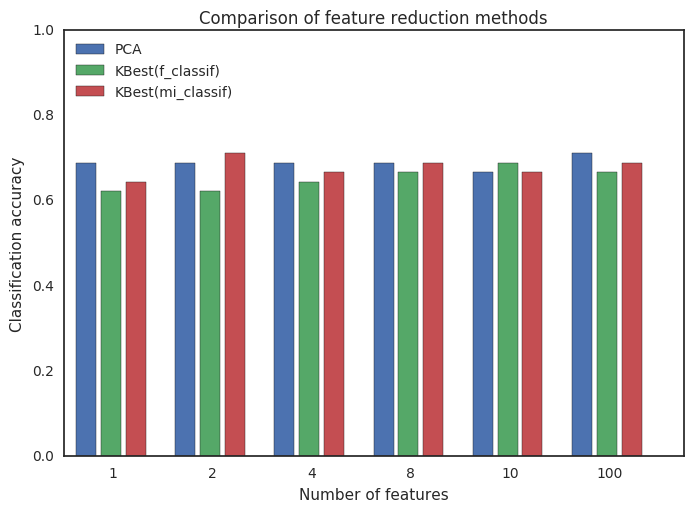

In [269]:
# regression problems:
#compare_dim_red_methods(normalize_pd(d, 0), round(md[response_column], 0), mode='regression')

# classification:
print('Accuracy for classifier param grid for response variable', response_column)
compare_dim_red_methods(normalize_pd(d, 0), md[response_column], mode='classif')

# PCA

In [287]:
comps, exvar, _ = get_pc(normalize_pd(d,0, 'normalize'))
comps.to_csv('data/PCs.tsv', sep='\t')

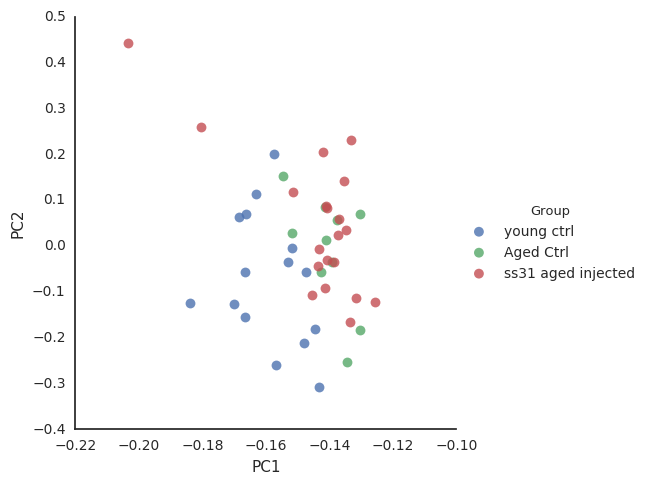

In [235]:
#plot_comps = get_plot_comps(comps, md)
p2 = sns.lmplot(x='PC1', y='PC2', hue='Group', data=plot_comps, ci=None, fit_reg=False,
               scatter_kws={"s":50})

In [236]:
print('Variance explained')
pd.DataFrame(exvar).T

Variance explained


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45
0,0.876072,0.049818,0.02414,0.011496,0.008524,0.006792,0.005663,0.005047,0.002583,0.002104,...,0.000006,0.000005,0.000004,0.000003,0.000002,0.000001,5.839728e-07,2.583595e-07,1.853142e-07,1.405365e-07


The first two components seem to actually cluster both aged groups together, with some difference between the 'aged' cluster and 'young' cluster. There are some outliers from the Group 'aged treated'...

In [237]:
#p2 = sns.lmplot(x='PC1', y='PC2', hue='Trial', data=plot_comps.sort_values('Trial').iloc[:10,:],
#                ci=None, fit_reg=False, scatter_kws={"s":50})#, y_jitter=0.01, x_jitter=0.01)

In [238]:
# clusterplots for samples 1) PC3, PCall, all_var

In [239]:
palette=sns.color_palette('colorblind', len(md.Group.drop_duplicates()))
if not 'Colour' in md.columns:
    md.insert(1, 'Colour', md.Group)
    for i,g in enumerate(md.Colour.drop_duplicates()):
        md.Colour[md.Colour == g] = [palette[i] for c in range(sum(md.Colour == g))]

In [240]:
md.head()

,Group,Colour,Animal
0,young ctrl,0,1.1
1,young ctrl,0.447059,1.2
2,young ctrl,0.698039,1.3
3,young ctrl,0,1.4
4,young ctrl,0.447059,3.2


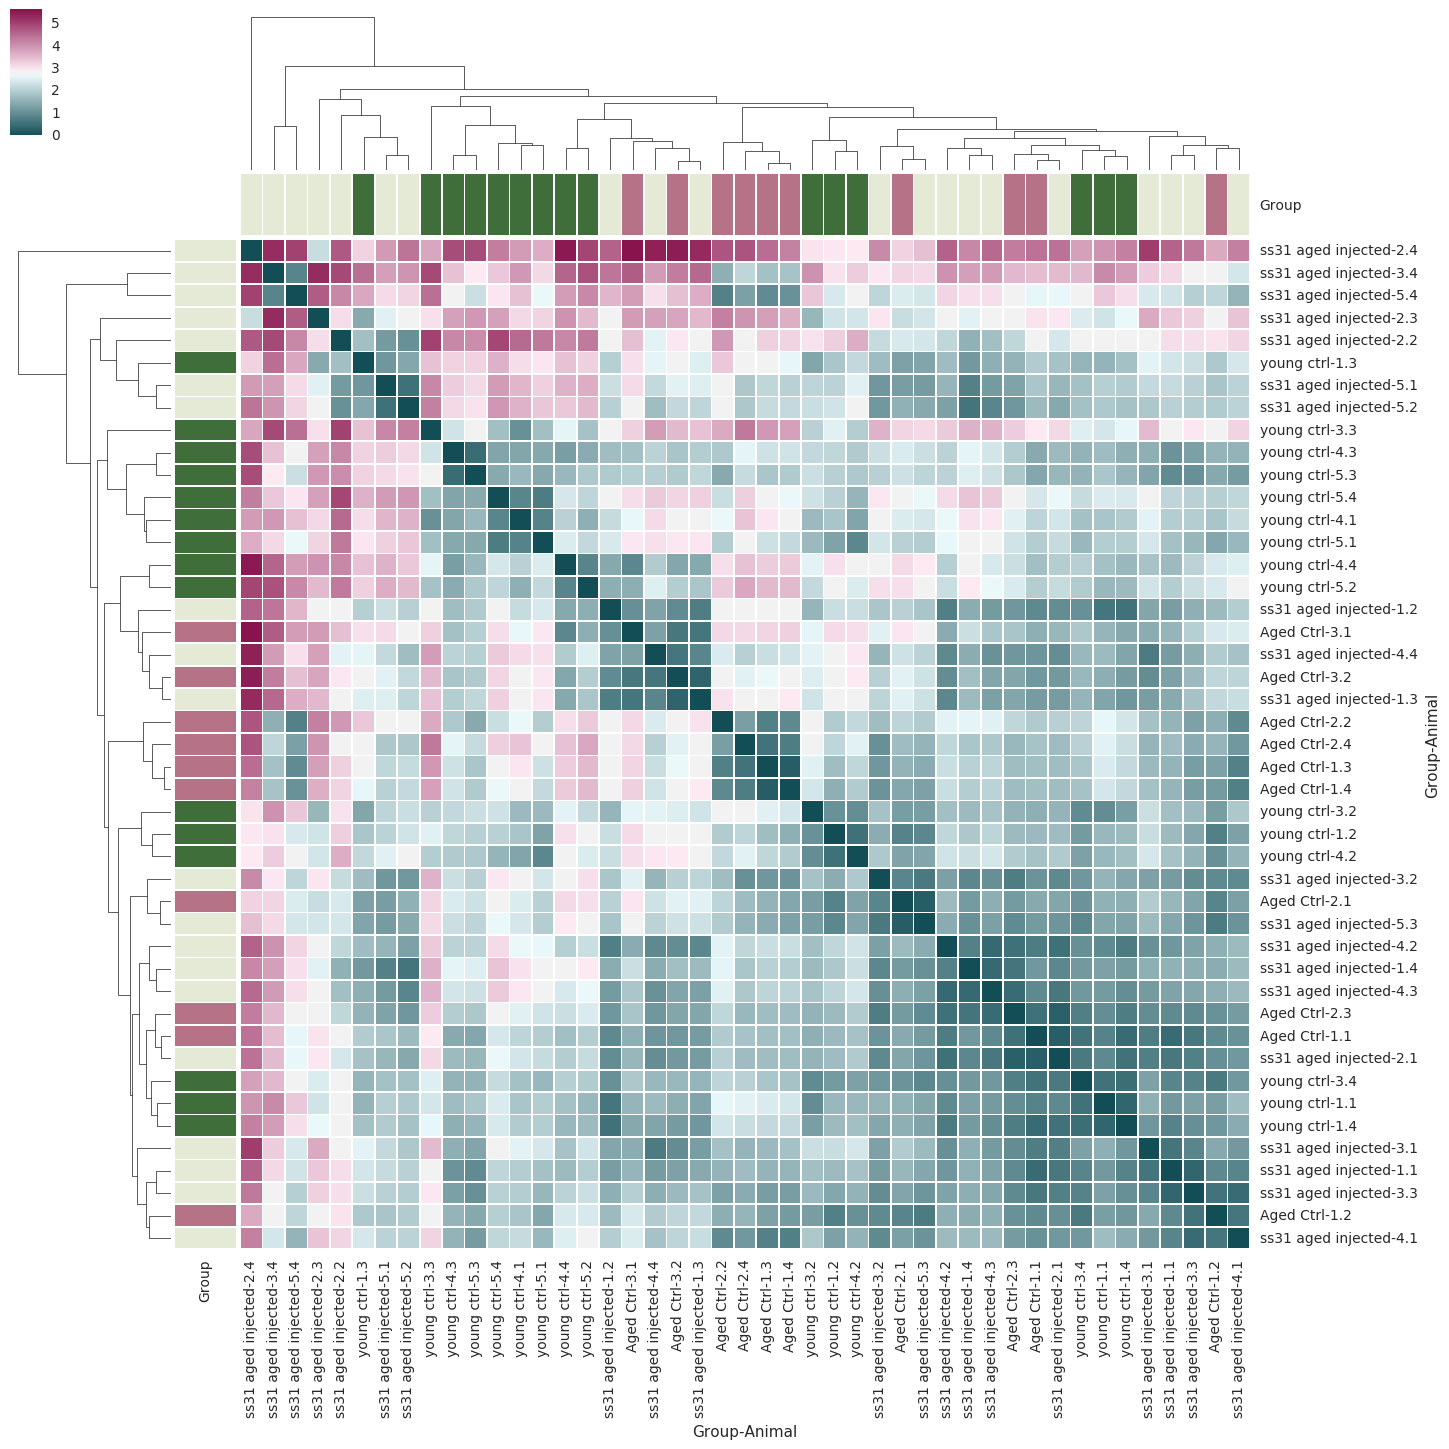

In [296]:
D = pd.DataFrame(pairwise_distances(comps.ix[:, :3],metric='mahalanobis'),
                columns = comps.index, index = comps.index)
#sns.clustermap(x);
p3 = distance_matrix_plots(D, "Group", figsize=(16,16));

# Differences between groups

### cluster separation - ?

### generate Gait Index; compare with one variable - ANOVA

In [313]:
GI = comps.ix[:, :1].rename(columns={'PC1': 'GI'})
GI.to_csv('data/GI.tsv', sep="\t")
GI['GI_scaled'] = scale(GI['GI'])
GI.describe()

,GI,GI_scaled
count,45.000000,4.500000e+01
mean,-0.148240,-1.571582e-15
std,0.015894,1.011300e+00
min,-0.203283,-3.502290e+00
25%,-0.154454,-3.953596e-01
50%,-0.143210,3.200667e-01
75%,-0.137697,6.708961e-01
max,-0.125688,1.434978e+00


In [286]:
[print(i) for i in manovaR('data/GI.tsv', 'GI~Group').values()];

            Df   Sum Sq   Mean Sq F value  Pr(>F)
Group        2 0.002776 0.0013881   6.991 0.00239 **
Residuals   42 0.008339 0.0001985
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### comparison with multiple variables - MANOVA

# Correlations L-R

In [358]:
corrs = corr_L_R(full_df)
print('Get those with *lowest* correlations')
#corrs.groupby(corrs.index.get_level_values(0)).apply(lambda x: x.sort_values('correlation', ascending=True))
corrs.sort_values('correlation', ascending=True)

Get those with *lowest* correlations


correlation
Group                                                         
ss31 aged injected H_BodySpeed_(cm/s)_Mean            0.001925
Aged Ctrl          F_MinIntensity_Mean                0.002450
young ctrl         F_MinIntensity_Mean                0.002692
ss31 aged injected F_BodySpeed_(cm/s)_Mean            0.002911
young ctrl         H_MinIntensity_Mean                0.004482
                   F_BodySpeed_(cm/s)_Mean            0.006507
                   H_BodySpeed_(cm/s)_Mean            0.007488
ss31 aged injected F_BodySpeedVariation_(%)_Mean      0.009124
Aged Ctrl          H_MinIntensity_Mean                0.010267
                   F_BodySpeed_(cm/s)_Mean            0.012837
ss31 aged injected H_StrideLength_(cm)_Mean           0.013699
                   F_StrideLength_(cm)_Mean           0.015067
                   F_MinIntensity_Mean                0.017602
Aged Ctrl          H_BodySpeed_(cm/s)_Mean            0.018651
                   F_PrintArea_(cm²)_Mean             0.020817
                   F_MaxContactArea_(cm²)_Mean        0.025220
young ctrl         H_BodySpeedVariation_(%)_Mean      0.025727
ss31 aged injected H_BodySpeedVariation_(%)_Mean      0.025785
young ctrl         F_StepCycle_(s)_Mean               0.026493
Aged Ctrl          H_BodySpeedVariation_(%)_Mean      0.030264
ss31 aged injected H_StepCycle_(s)_Mean               0.030369
young ctrl         F_BodySpeedVariation_(%)_Mean      0.031827
Aged Ctrl          H_MaxContactMeanIntensity_Mean     0.032291
                   H_PrintLength_(cm)_Mean            0.033084
                   H_MaxContactArea_(cm²)_Mean        0.041330
young ctrl         H_MaxContactMeanIntensity_Mean     0.044705
Aged Ctrl          F_PrintLength_(cm)_Mean            0.045677
young ctrl         F_MaxContactMeanIntensity_Mean     0.046646
ss31 aged injected H_MinIntensity_Mean                0.049736
Aged Ctrl          H_PrintArea_(cm²)_Mean             0.051689
...                                                        ...
                   F_Stand_(s)_Mean                   0.498055
young ctrl         F_MaxIntensityAt_(%)_Mean          0.499015
ss31 aged injected H_MaxContactAt_(%)_Mean            0.500526
                   H_MaxContactArea_(cm²)_Mean        0.502035
Aged Ctrl          H_InitialDualStance_(s)_Mean       0.504238
young ctrl         F_StandIndex_Mean                  0.505539
ss31 aged injected F_TerminalDualStance_(s)_Mean      0.518439
                   F_DutyCycle_(%)_Mean               0.524204
Aged Ctrl          H_StepCycle_(s)_Mean               0.542420
ss31 aged injected H_PrintArea_(cm²)_Mean             0.547638
Aged Ctrl          F_TerminalDualStance_(s)_Mean      0.557188
young ctrl         H_SingleStance_(s)_Mean            0.570791
ss31 aged injected F_PrintWidth_(cm)_Mean             0.583211
                   F_PrintLength_(cm)_Mean            0.587805
                   H_DutyCycle_(%)_Mean               0.608820
Aged Ctrl          F_DutyCycle_(%)_Mean               0.618121
young ctrl         H_DutyCycle_(%)_Mean               0.619875
Aged Ctrl          F_SingleStance_(s)_Mean            0.625851
                   F_InitialDualStance_(s)_Mean       0.648499
ss31 aged injected H_PrintLength_(cm)_Mean            0.666861
                   F_MaxIntensityAt_(%)_Mean          0.682724
young ctrl         F_TerminalDualStance_(s)_Mean      0.694058
Aged Ctrl          F_MaxIntensityAt_(%)_Mean          0.754061
young ctrl         F_MaxContactAt_(%)_Mean            0.769689
                   H_TerminalDualStance_(s)_Mean      0.795289
ss31 aged injected H_PrintWidth_(cm)_Mean             0.817555
young ctrl         F_DutyCycle_(%)_Mean               0.819050
                   F_InitialDualStance_(s)_Mean       0.849692
                   H_Swing_(s)_Mean                   0.852383
                   H_InitialDualStance_(s)_Mean       1.039210

[144 rows x 1 columns]

# Notes

In [ ]:
# heatmap: linkages!
p3.dendrogram_col.linkage # linkage matrix for columns
p3.dendrogram_row.linkage # linkage matrix for rows